In [2]:
## confusion matrix 그리는 코드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, output_directory, name, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('threshold: '+name+'% '+title)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.subplots_adjust(left=0.15, right=0.9, bottom=0.15, top=0.9)
    plt.savefig(output_directory+f'{name}.png', facecolor='#eeeeee')
    plt.show()

In [ ]:
## threshold 측정할 파일들 리스트업

import os
liris = pd.DataFrame(os.listdir('/home/projects/Metaverse2021/LIRISCSE/videos_208/'), columns=['file'])
liris_file_split = liris['file'].str.split('.')
liris['name'] = liris_file_split.str.get(0)
liris_name_split = liris['name'].str.split('_')
liris['kid'] = liris_name_split.str.get(0)
liris['emotion'] = liris_name_split.str.get(1)
emo_sub = []
for i in liris_name_split.str.get(2):
    if type(i) == float:
        emo_sub.append(np.nan)
    else:
        if not i.isdigit():
            emo_sub.append(i)
        else:
            emo_sub.append(np.nan)
liris['emotion2'] = emo_sub
# liris['true'] = liris['emotion']+liris['emotion2']

# 멀티 label data 제외
single_liris = liris[liris['emotion2'].isnull()].reset_index()
single_liris = single_liris[single_liris['emotion']!='confusing']

name = []
emotion = []
for idx in range(len(single_liris)):
    file = single_liris['name'][idx]
    emo = single_liris['emotion'][idx]

    # fer.py를 통해 생성한 df 호출
    df1 = pd.read_csv('/home/heemin/mv/dir/liriscse/'+file+'.csv')[['total_count', 'emotion']]

    # 비디오 내에 얼굴인식이 아예 안된 데이터 제외
    if not len(df1)==0:
        end_frame = int(df1['total_count'][-1:])
        df2 = pd.merge(pd.DataFrame([i for i in range(1, end_frame+1)], columns=['total_count']), df1, how='outer').fillna('Neutral')
        name.append(file)
        emotion.append(emo)
        df3 = df2
        df3.to_csv('/home/heemin/mv/dir/liriscse_crop/'+file+'.csv')
liris_final = pd.DataFrame({'name':name, 'emotion':emotion})

liris_final.to_excel('/home/heemin/mv/dir/LIRISCSE_label.xlsx', index=False)
liris_final = pd.read_excel('/home/heemin/mv/dir/LIRISCSE_label.xlsx', engine='openpyxl')

## label 정리 7 -> 3 label로
nega = ['disgust', 'fear', 'surprise', 'sad', 'anger','suprise']
happ = ['happy']
liris_final['Neutral'] = 0
for emotion in nega:
    liris_final.loc[liris_final['emotion'] == emotion, 'Neutral'] = 1
for emotion in happ:
    liris_final.loc[liris_final['emotion'] == emotion, 'Neutral'] = 2

## 데이터셋에서 제공하는 자체 label table; 30명 교차 검증 label
df = pd.read_excel('/home/heemin/mv/dir/VideoStimSet_SuppTable1.xlsx', engine='openpyxl')

## label 중 60%이상 일치한 것만 사용; 데이터셋 논문에서도 60% 권장
df = df[df['% correct']>=0.6]

In [16]:
## DuckEES 데이터셋은 파일 이름이 label이어서 다르게 label을 리스트업
import os
import natsort
from collections import Counter
fl = os.listdir('/home/heemin/mv/dir/DuckEEs')
file_list = natsort.natsorted(fl)

drop_file =[]
for file in file_list:
    df1 = pd.read_csv('/home/heemin/mv/dir/DuckEEs/'+file)[['total_count', 'emotion']]
    if len(df1) == 0:
        drop_file.append(file)

true_label = df[['video', 'mode']]
true_label['video'] = df['video'].str[6:]
drop_filename = []

for file in drop_file:
    drop_filename.append(file.split('.')[0])
drop_df = pd.DataFrame(drop_filename, columns=['video'])
drop_df['bad'] = 1
label1 = pd.merge(true_label, drop_df, how='left', on='video')
label2 = label1[label1['bad'].isnull()].iloc[:,0:-1]
nega = ['disgust', 'fear', 'embarrassment', 'sadness']
happ = ['happiness', 'pride']

label2['Neutral'] = 0
for emotion in nega:
    label2.loc[label2['mode'] == emotion, 'Neutral'] = 1
for emotion in happ:
    label2.loc[label2['mode'] == emotion, 'Neutral'] = 2
# label2 = label2.reset_index()

# pride, embaressment data 제거
label2 = label2[~label2['mode'].str.contains('pride', na = False)]
label2 = label2[~label2['mode'].str.contains('embar', na = False)]
label2 = label2.reset_index()

label2.to_excel('/home/heemin/mv/dir/DuckEEs_label.xlsx', index=False)
label2 = label2[['video', 'mode', 'Neutral']]
label2 = pd.read_excel('/home/heemin/mv/dir/DuckEEs_label.xlsx', engine='openpyxl')


## 데이터에 frame과 emotion만 남김
for idx in range(len(label2)):
    file = label2['video'][idx]
    df1 = pd.read_csv('/home/heemin/mv/dir/DuckEEs/'+file+'.csv')[['total_count', 'emotion']]
    end_frame = int(df1['total_count'][-1:])
    df2 = pd.merge(pd.DataFrame([i for i in range(1, end_frame+1)], columns=['total_count']), df1, how='outer').fillna('Neutral')
    
    df3 = df2
    df3.to_csv('/home/heemin/mv/dir/DuckEEs_crop/'+file+'.csv')

label2 = label2.rename(columns={'video':'name', 'mode':'emotion'})[['name','emotion', 'Neutral']]

## 두 데이터 셋의 label 하나로.
label_total = pd.concat([liris_final, label2]).reset_index()

In [39]:
# liris_duckees 폴더를 만들어서 crop csv를 전부 넣어줌

In [34]:
## DuckEES와 LIRIS 데이터셋의 label 통일

emotion_dict = {'Disgust':'Disgust', 'Fear':'Fear', 'Happy':'Happy', 'Sad':'Sad', 'Neutral':'Neutral', 'Suprise':'Surprise', 'Angry':'Angry'}
total_dict = {'disgust':'Disgust', 'fear':'Fear', 'happiness':'Happy', 'sadness':'Sad', 'neutral':'Neutral',
              'happy':'Happy', 'sad':'Sad', 'suprise':'Surprise', 'surprise':'Surprise', 'anger':'Angry'}

In [37]:
## 비교대상이었던 Top 1
## 데이터 내에 가장 많이 인식된 감정을 대표 감정으로.

import os
def top1(emotion_dict, data_dict, table_data, data_directory, output_directory, target_emotion='Neutral'):
    if not os.path.exists(output_directory):    # 경로에 해당하는 디렉토리가 존재하지 않으면
        os.makedirs(output_directory)           # 디렉토리 생성
        print(f"디렉토리 '{output_directory}'가 생성되었습니다.")
    else:
        print(f"디렉토리 '{output_directory}'가 이미 존재합니다.")

    emo_list = sorted(list(set(emotion_dict.values())))
    label_number = len(emo_list)
    bad_data = []
    cf_matrix = np.zeros([label_number, label_number])
    for i in range(len(table_data)):
        file = table_data['name'][i]
        df = pd.read_csv(data_directory+file+'.csv', index_col=0)
        label = table_data.loc[table_data['name'] == file]['emotion'][i]

        l1 = df['total_count'].tolist()
        l2 = df['emotion'].tolist()
        df1 = pd.DataFrame([l1,l2]).T
        df1['index'] = df1[0]
        a = list(range(l1[-1]+1))
        index_df = pd.DataFrame(a, columns=['index'])
        df2 = pd.merge(index_df, df1, how="outer")
        df2 = df2.fillna('Neutral')
        emolist = df2[1].to_list()
        emocount = Counter(emolist)
        top3 = emocount.most_common(n=3)
        l3 = []

        if top3[0][0] == 'none':
            l3.append(target_emotion)
        else:
            l3.append(top3[0][0])

        for emotion in l3:
            for selected_idx in range(label_number):
                slctd_emo = emo_list[selected_idx]
                if data_dict[label] == slctd_emo:
                    if emotion_dict[emotion] == slctd_emo:
                        cf_matrix[selected_idx][selected_idx] += 1
                    for rest_idx in range(label_number):
                        if rest_idx != selected_idx: 
                            if emotion_dict[emotion] == emo_list[rest_idx]:
                                cf_matrix[selected_idx][rest_idx] += 1
                            bad_data.append([file, emotion, label])
                                # print(file, emotion, label, emotion, total_dict[label])

    plot_confusion_matrix(cf_matrix.astype(int), output_directory, 'Top1', target_names=emo_list, normalize=False)
    # plt.savefig(output_directory+f'{str(thre)}.png')

In [38]:
import os
def threshold(emotion_dict, data_dict, table_data, data_directory, output_directory, target_emotion='Neutral'):
    if not os.path.exists(output_directory):    # 경로에 해당하는 디렉토리가 존재하지 않으면
        os.makedirs(output_directory)           # 디렉토리 생성
        print(f"디렉토리 '{output_directory}'가 생성되었습니다.")
    else:
        print(f"디렉토리 '{output_directory}'가 이미 존재합니다.")

    emo_list = sorted(list(set(emotion_dict.values())))
    label_number = len(emo_list)
    for thre in range(0, 100, 5): # threshold은 0.00부터 1.00까지 0.05 단위로 최적의 threshold가 있는지 체크
        threshold = thre / 100
        bad_data = []

        cf_matrix = np.zeros([label_number, label_number]) # cf를 그리기 위한 vector
        
        for i in range(len(table_data)):
            file = table_data['name'][i]
            df = pd.read_csv(data_directory+file+'.csv', index_col=0) # 데이터 호출 (df 형태)
            label = table_data.loc[table_data['name'] == file]['emotion'][i] # 레이블 매칭

            # df 재구축 가로->세로 (형식상 필요)
            l1 = df['total_count'].tolist() # frame 열을 리스트로
            l2 = df['emotion'].tolist() # emotion 열을 리스트로
            df1 = pd.DataFrame([l1,l2]).T 
            df1['index'] = df1[0]
            a = list(range(l1[-1]+1))
            index_df = pd.DataFrame(a, columns=['index'])
            df2 = pd.merge(index_df, df1, how="outer")
            df2 = df2.fillna('Neutral')
            emolist = df2[1].to_list()
            emocount = Counter(emolist) # 총 개수 계산
            top3 = emocount.most_common(n=3) # 상위 3개의 감정과 그 감정의 개수
            l3 = []

            total_len = len(df2)
            p10_len = int(total_len * threshold)

            # 대표감정을 조건식으로 찾음
            if top3[0][0] == 'none': # 1위 감정이 "인식불가" 이면
                if len(top3) == 1: # 그 "none"만 있을때
                    l3.append(target_emotion) # 대표감정을 'Neutral'로 한다 (target_emotion의 defualt)
                elif top3[1][0] == target_emotion: # 2위 감정이 존재하는데 'Neutral'이고
                    if len(top3) == 3: # 3위 감정도 존재하면
                        if top3[2][1] >= p10_len: # 3위 감정이 threshold를 넘기는지 확인
                            l3.append(top3[2][0]) # 넘기면 3위 감정이 대표 감정 (비디오 1개의)
                        else:
                            l3.append(top3[1][0]) # 넘기지 못하면 'Neutral'
                    else:
                        l3.append(top3[1][0]) # 2위인 'Neutral'만 존재하면 'Neutral'을 대표감정

            elif top3[0][0] == target_emotion: # 1위 감정이 'Neutral'일때
                if len(top3) == 1: # 'Neutral'만 있다면
                    l3.append(target_emotion) # 'Neutral'을 대표감정
                elif top3[1][0] == 'none': # 2위 감정이 'none'이고
                    if len(top3) == 2: # 2위 감정까지만 존재하면 
                        l3.append(target_emotion) # 대표 감정은 'Neutral'
                    else:
                        if top3[2][1] >= p10_len: # 3위 감정이 존재하고 threshold를 넘겼다면
                            l3.append(top3[2][0]) # 해당 감정을 대표감정
                        else:
                            l3.append(top3[0][0]) # 아니라면 'Neutral'을 대표감정
                else:
                    if top3[1][1] >= p10_len: # 2위 감정이 'none'이 아니고 threshold를 넘겼다면
                        l3.append(top3[1][0]) # 해당 감정을 대표감정
                    else:
                        l3.append(top3[0][0]) # 아니라면 'Neutral'을 대표감정

            else:
                l3.append(top3[0][0]) # 감정이 1위라면 해당 감정을 대표 감정으로

            ## 개수 측정
            for emotion in l3:
                for selected_idx in range(label_number):
                    slctd_emo = emo_list[selected_idx]
                    if data_dict[label] == slctd_emo:
                        if emotion_dict[emotion] == slctd_emo:
                            cf_matrix[selected_idx][selected_idx] += 1
                        for rest_idx in range(label_number):
                            if rest_idx != selected_idx: 
                                if emotion_dict[emotion] == emo_list[rest_idx]:
                                    cf_matrix[selected_idx][rest_idx] += 1
                                bad_data.append([file, emotion, label])
                                    # print(file, emotion, label, emotion, total_dict[label])

        plot_confusion_matrix(cf_matrix.astype(int), output_directory, str(thre), target_names=emo_list, normalize=False)
        # plt.savefig(output_directory+f'{str(thre)}.png')

디렉토리 '/home/heemin/mv/dir/img/label3/'가 이미 존재합니다.


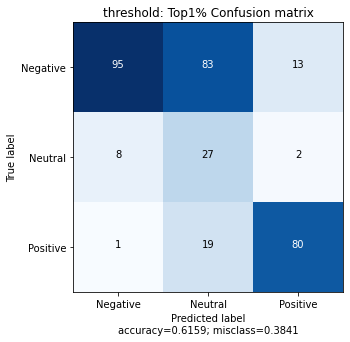

In [39]:
## 3 label로 확인해본 Top 1
emotion_dict = {'Disgust':'Negative', 'Sad':'Negative', 'Fear':'Negative', 'Happy':'Positive', 'Suprise':'Negative', 'Neutral':'Neutral', 'Angry':'Negative'}
total_dict = {'disgust':'Negative', 'fear':'Negative', 'happiness':'Positive', 'sadness':'Negative', 'neutral':'Neutral',
              'happy':'Positive', 'sad':'Negative', 'suprise':'Negative', 'surprise':'Negative', 'anger':'Negative'}
top1(emotion_dict, total_dict, label_total, '/home/heemin/mv/dir/liris_duckees/', '/home/heemin/mv/dir/img/label3/')

디렉토리 '/home/heemin/mv/dir/img/label3/'가 이미 존재합니다.


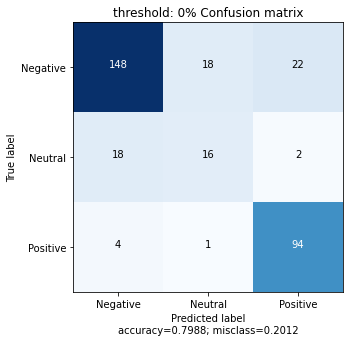

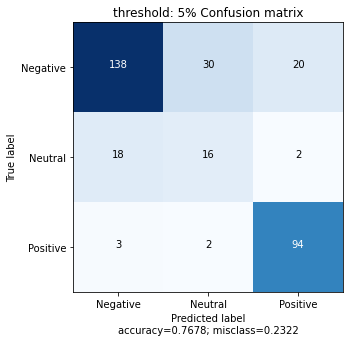

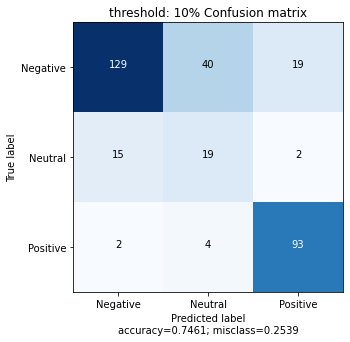

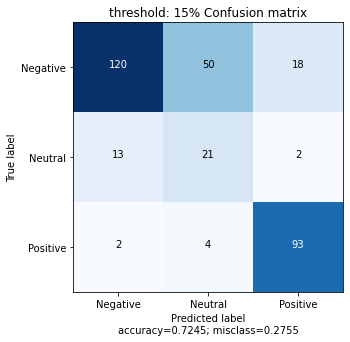

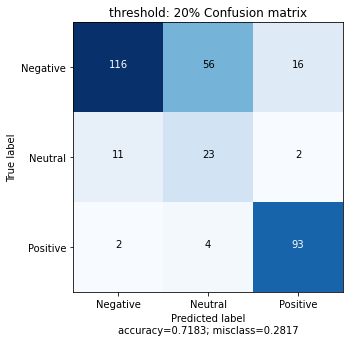

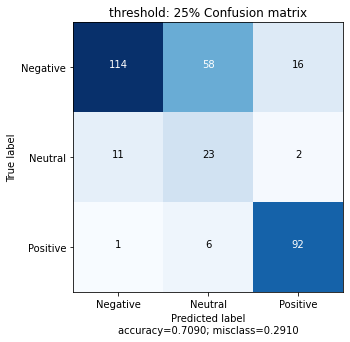

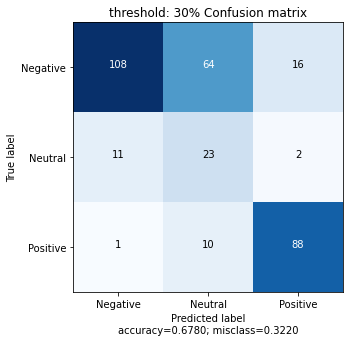

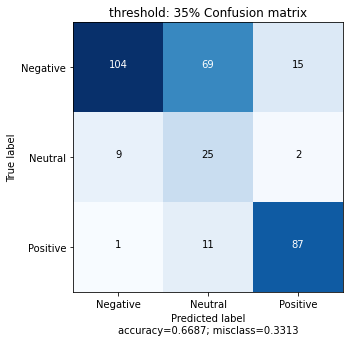

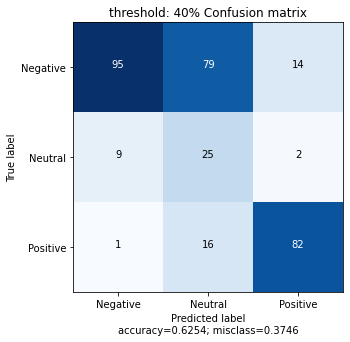

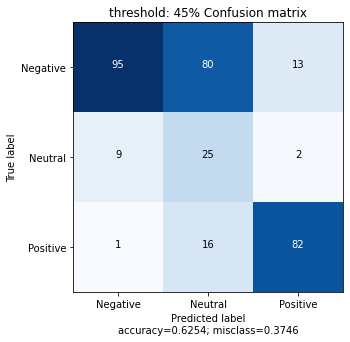

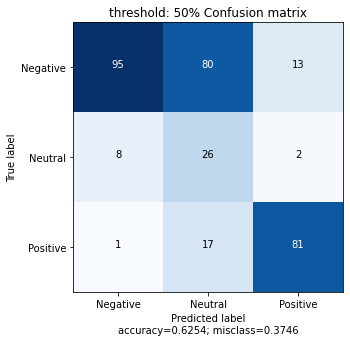

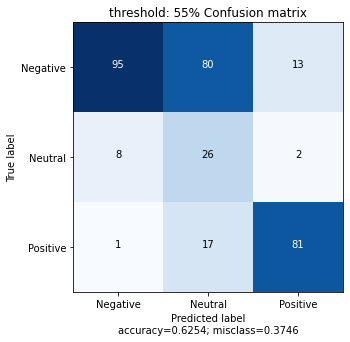

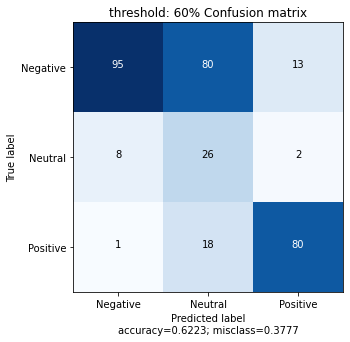

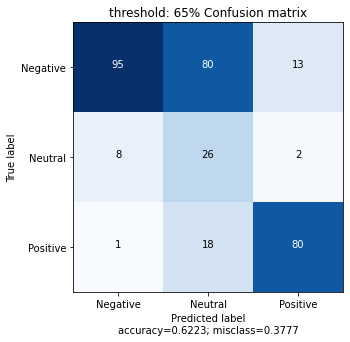

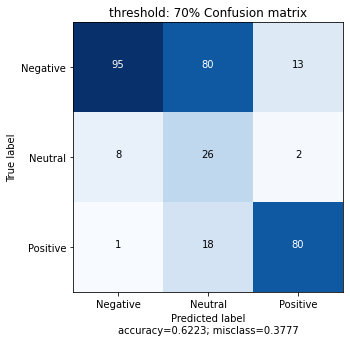

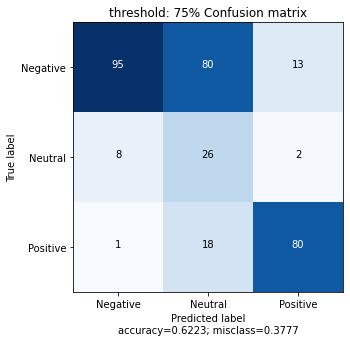

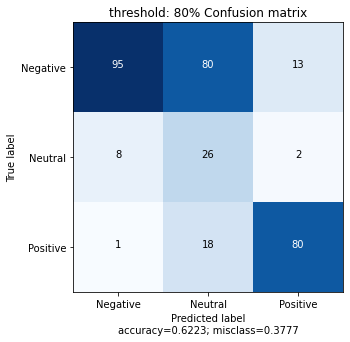

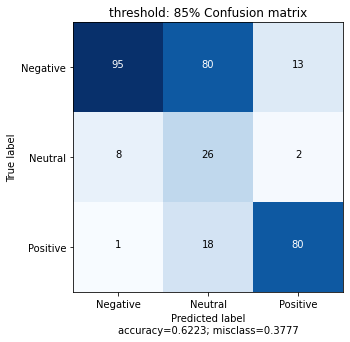

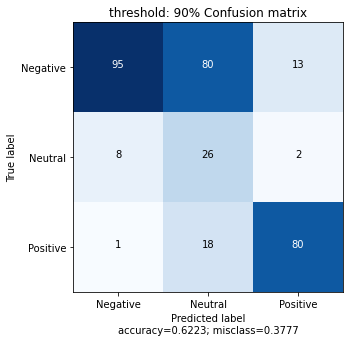

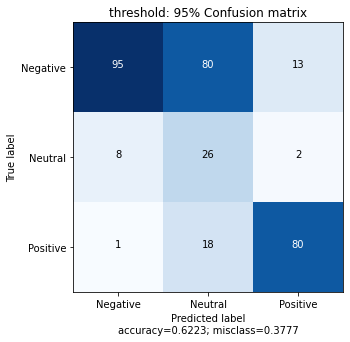

In [40]:
## 3 label로 확인해본 Threshold; 최적의 threshold는 confusion matrix보고 찾아야함
emotion_dict = {'Disgust':'Negative', 'Sad':'Negative', 'Fear':'Negative', 'Happy':'Positive', 'Suprise':'Negative', 'Neutral':'Neutral', 'Angry':'Negative'}
total_dict = {'disgust':'Negative', 'fear':'Negative', 'happiness':'Positive', 'sadness':'Negative', 'neutral':'Neutral',
              'happy':'Positive', 'sad':'Negative', 'suprise':'Negative', 'surprise':'Negative', 'anger':'Negative'}
threshold(emotion_dict, total_dict, label_total, '/home/heemin/mv/dir/liris_duckees/', '/home/heemin/mv/dir/img/label3/')

디렉토리 '/home/heemin/mv/dir/img/label7/'가 이미 존재합니다.


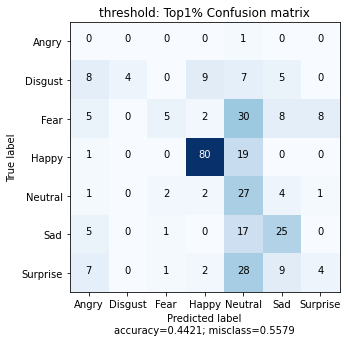

In [49]:
## 7 label
emotion_dict = {'Disgust':'Disgust', 'Sad':'Sad', 'Fear':'Fear', 'Happy':'Happy', 'Suprise':'Surprise', 'Neutral':'Neutral', 'Angry':'Angry'}
total_dict = {'disgust':'Disgust', 'fear':'Fear', 'happiness':'Happy', 'sadness':'Sad', 'neutral':'Neutral',
              'happy':'Happy', 'sad':'Sad', 'suprise':'Surprise', 'surprise':'Surprise', 'anger':'Angry'}
top1(emotion_dict, total_dict, label_total, '/home/heemin/mv/dir/liris_duckees/', '/home/heemin/mv/dir/img/label7/')

디렉토리 '/home/heemin/mv/dir/img/label7/'가 이미 존재합니다.


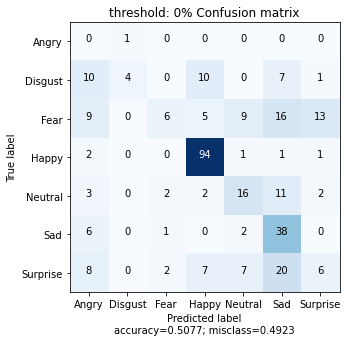

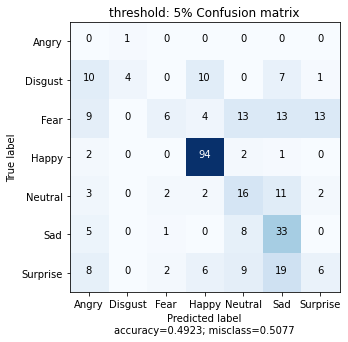

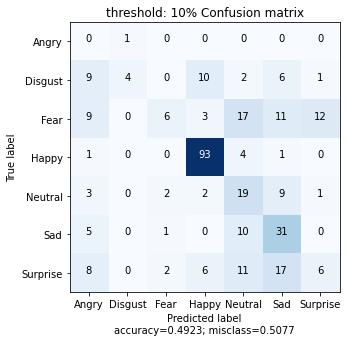

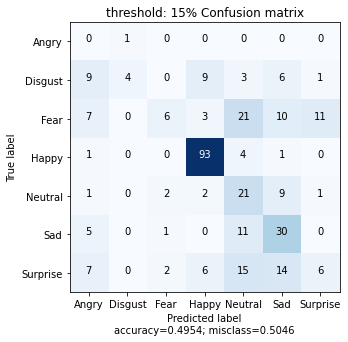

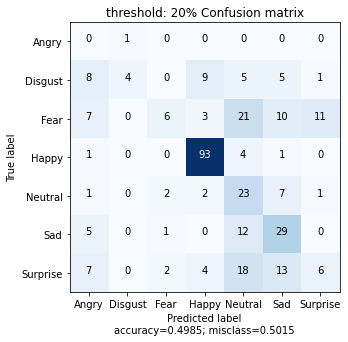

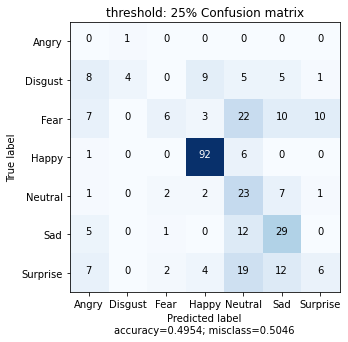

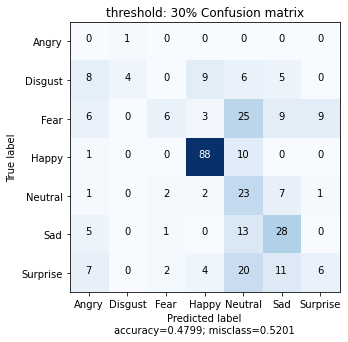

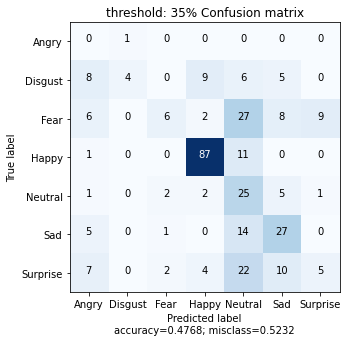

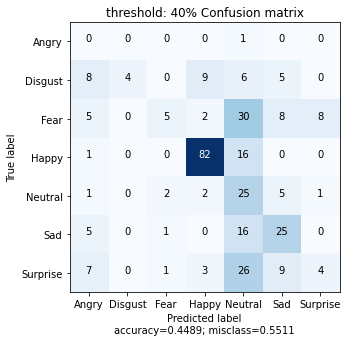

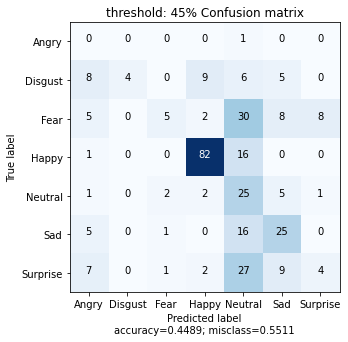

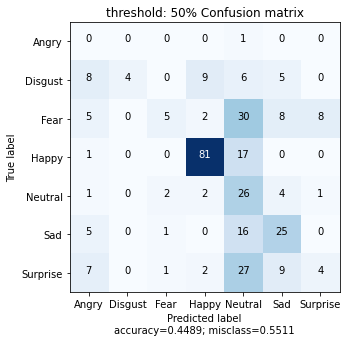

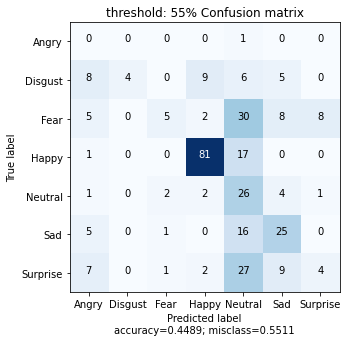

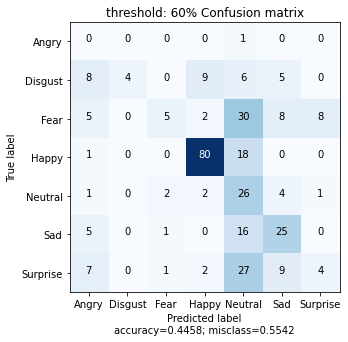

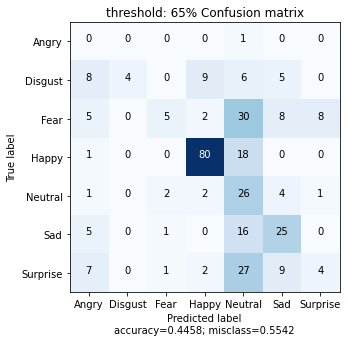

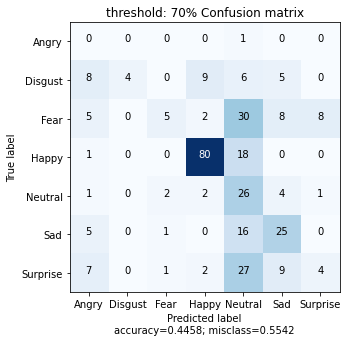

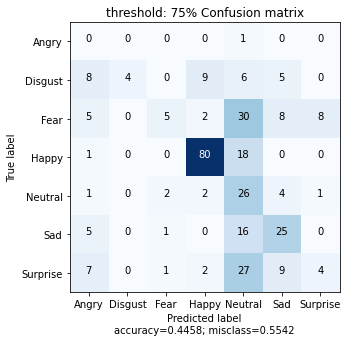

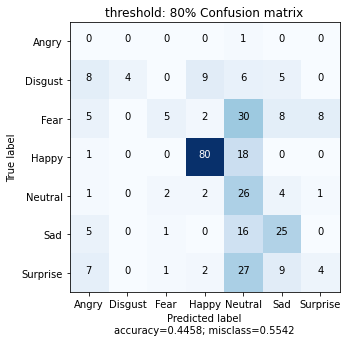

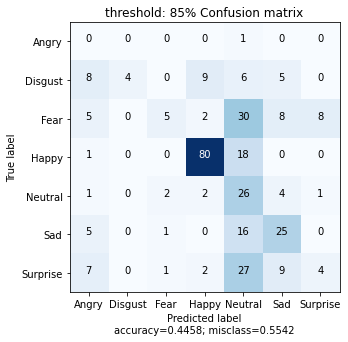

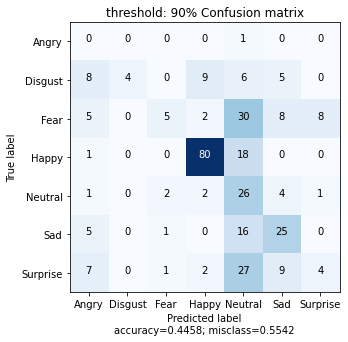

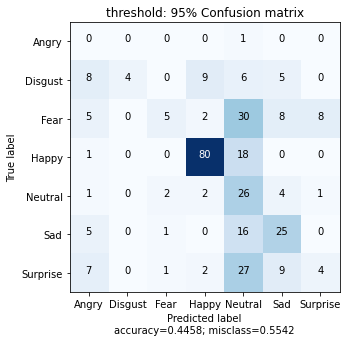

In [45]:
emotion_dict = {'Disgust':'Disgust', 'Sad':'Sad', 'Fear':'Fear', 'Happy':'Happy', 'Suprise':'Surprise', 'Neutral':'Neutral', 'Angry':'Angry'}
total_dict = {'disgust':'Disgust', 'fear':'Fear', 'happiness':'Happy', 'sadness':'Sad', 'neutral':'Neutral',
              'happy':'Happy', 'sad':'Sad', 'suprise':'Surprise', 'surprise':'Surprise', 'anger':'Angry'}
threshold(emotion_dict, total_dict, label_total, '/home/heemin/mv/dir/liris_duckees/', '/home/heemin/mv/dir/img/label7/')

In [ ]:
# liris 만 3 label
emotion_dict = {'Disgust':'Negative', 'Sad':'Negative', 'Fear':'Negative', 'Happy':'Positive', 'Suprise':'Negative', 'Neutral':'Neutral', 'Angry':'Negative'}
total_dict = {'disgust':'Negative', 'fear':'Negative', 'happiness':'Positive', 'sadness':'Negative', 'neutral':'Neutral',
              'happy':'Positive', 'sad':'Negative', 'suprise':'Negative', 'surprise':'Negative', 'anger':'Negative'}
top1(emotion_dict, total_dict, liris_final, '/home/heemin/mv/dir/liriscse_crop/', '/home/heemin/mv/dir/img/liriscse_l3/')

In [ ]:
# liris 만 3 label
emotion_dict = {'Disgust':'Negative', 'Sad':'Negative', 'Fear':'Negative', 'Happy':'Positive', 'Suprise':'Negative', 'Neutral':'Neutral', 'Angry':'Negative'}
total_dict = {'disgust':'Negative', 'fear':'Negative', 'happiness':'Positive', 'sadness':'Negative', 'neutral':'Neutral',
              'happy':'Positive', 'sad':'Negative', 'suprise':'Negative', 'surprise':'Negative', 'anger':'Negative'}
threshold(emotion_dict, total_dict, liris_final, '/home/heemin/mv/dir/liriscse_crop/', '/home/heemin/mv/dir/img/liriscse_l3/')

In [ ]:
# liris 만 7 label
emotion_dict = {'Disgust':'Disgust', 'Sad':'Sad', 'Fear':'Fear', 'Happy':'Happy', 'Suprise':'Surprise', 'Neutral':'Neutral', 'Angry':'Angry'}
total_dict = {'disgust':'Disgust', 'fear':'Fear', 'happiness':'Happy', 'sadness':'Sad', 'neutral':'Neutral',
              'happy':'Happy', 'sad':'Sad', 'suprise':'Surprise', 'surprise':'Surprise', 'anger':'Angry'}
top1(emotion_dict, total_dict, liris_final, '/home/heemin/mv/dir/liriscse_crop/', '/home/heemin/mv/dir/img/liriscse_l7/')

In [ ]:
# liris 만 7 label
emotion_dict = {'Disgust':'Disgust', 'Sad':'Sad', 'Fear':'Fear', 'Happy':'Happy', 'Suprise':'Surprise', 'Neutral':'Neutral', 'Angry':'Angry'}
total_dict = {'disgust':'Disgust', 'fear':'Fear', 'happiness':'Happy', 'sadness':'Sad', 'neutral':'Neutral',
              'happy':'Happy', 'sad':'Sad', 'suprise':'Surprise', 'surprise':'Surprise', 'anger':'Angry'}
threshold(emotion_dict, total_dict, liris_final, '/home/heemin/mv/dir/liriscse_crop/', '/home/heemin/mv/dir/img/liriscse_l7/')

In [ ]:
# DuckEES 3 label
emotion_dict = {'Disgust':'Negative', 'Sad':'Negative', 'Fear':'Negative', 'Happy':'Positive', 'Suprise':'Negative', 'Neutral':'Neutral', 'Angry':'Negative'}
total_dict = {'disgust':'Negative', 'fear':'Negative', 'happiness':'Positive', 'sadness':'Negative', 'neutral':'Neutral',
              'happy':'Positive', 'sad':'Negative', 'suprise':'Negative', 'surprise':'Negative', 'anger':'Negative'}
top1(emotion_dict, total_dict, label2, '/home/heemin/mv/dir/DuckEEs_crop/', '/home/heemin/mv/dir/img/DuckEEs_l3/')

In [ ]:
# DuckEES 3 label
emotion_dict = {'Disgust':'Negative', 'Sad':'Negative', 'Fear':'Negative', 'Happy':'Positive', 'Suprise':'Negative', 'Neutral':'Neutral', 'Angry':'Negative'}
total_dict = {'disgust':'Negative', 'fear':'Negative', 'happiness':'Positive', 'sadness':'Negative', 'neutral':'Neutral',
              'happy':'Positive', 'sad':'Negative', 'suprise':'Negative', 'surprise':'Negative', 'anger':'Negative'}
threshold(emotion_dict, total_dict, label2, '/home/heemin/mv/dir/DuckEEs_crop/', '/home/heemin/mv/dir/img/DuckEEs_l3/')

In [ ]:
# DuckEES 7 label
emotion_dict = {'Disgust':'Disgust', 'Sad':'Sad', 'Fear':'Fear', 'Happy':'Happy', 'Suprise':'Surprise', 'Neutral':'Neutral', 'Angry':'Angry'}
total_dict = {'disgust':'Disgust', 'fear':'Fear', 'happiness':'Happy', 'sadness':'Sad', 'neutral':'Neutral',
              'happy':'Happy', 'sad':'Sad', 'suprise':'Surprise', 'surprise':'Surprise', 'anger':'Angry'}
top1(emotion_dict, total_dict, label2, '/home/heemin/mv/dir/DuckEEs_crop/', '/home/heemin/mv/dir/img/DuckEEs/')

In [ ]:
# DuckEES 7 label
emotion_dict = {'Disgust':'Disgust', 'Sad':'Sad', 'Fear':'Fear', 'Happy':'Happy', 'Suprise':'Surprise', 'Neutral':'Neutral', 'Angry':'Angry'}
total_dict = {'disgust':'Disgust', 'fear':'Fear', 'happiness':'Happy', 'sadness':'Sad', 'neutral':'Neutral',
              'happy':'Happy', 'sad':'Sad', 'suprise':'Surprise', 'surprise':'Surprise', 'anger':'Angry'}
threshold(emotion_dict, total_dict, label2, '/home/heemin/mv/dir/DuckEEs_crop/', '/home/heemin/mv/dir/img/DuckEEs/')

In [ ]:
# DuckEES 7 label
emotion_dict = {'Disgust':'Disgust', 'Sad':'Sad', 'Fear':'Fear', 'Happy':'Happy', 'Suprise':'Surprise', 'Neutral':'Neutral', 'Angry':'Angry'}
total_dict = {'disgust':'Disgust', 'fear':'Fear', 'happiness':'Happy', 'sadness':'Sad', 'neutral':'Neutral',
              'happy':'Happy', 'sad':'Sad', 'suprise':'Surprise', 'surprise':'Surprise', 'anger':'Angry'}
threshold(emotion_dict, total_dict, label_total, '/home/heemin/mv/dir/liris_duckees/', '/home/heemin/mv/dir/img/label7/')

In [ ]:
# DuckEES 7 label
emotion_dict = {'Disgust':'Disgust', 'Sad':'Sad', 'Fear':'Fear', 'Happy':'Happy', 'Suprise':'Surprise', 'Neutral':'Neutral', 'Angry':'Angry'}
total_dict = {'disgust':'Disgust', 'fear':'Fear', 'happiness':'Happy', 'sadness':'Sad', 'neutral':'Neutral',
              'happy':'Happy', 'sad':'Sad', 'suprise':'Surprise', 'surprise':'Surprise', 'anger':'Angry'}
threshold(emotion_dict, total_dict, label_total, '/home/heemin/mv/dir/liris_duckees/', '/home/heemin/mv/dir/img/label7/')